# COMP 6940 Assignment #4 

#### Kevan Lee Lum

Due Friday 13th April 2018

Text Classification and such

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from string import punctuation
from sklearn import svm
from sklearn.utils import shuffle
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
from nltk import ngrams
from itertools import chain

from sklearn.metrics import recall_score, f1_score

# Warm Up

#### Write a Python function (from scratch) which takes the corpus and creates a vector representation of the corpus

In [2]:
corpus = ['Apple Orange Orange Apple', # [ 2.  0.  2.]
  'Apple Banana Apple Banana', # [ 2.  2.  0.]
  'Banana Apple Banana Banana Banana Apple', # [ 2.  4.  0.]
  'Banana Orange Banana Banana Orange Banana', #[ 0.  4.  2.]
  'Banana Apple Banana Banana Orange Banana'] # [ 1.  4.  1.]

Using the bag of words model, we can take out the unique words in the corpus as a set, sort the set in alphabetical order, and then count the number of the times the words appear in each document. We can see that there are only three words to deal with, so it makes sense than an array of three items is expected.

In [3]:
words = []
for x in corpus:
    y = x.split(" ")
    for z in y:
        if z not in words:
            words.append(z)
sorted_words = sorted(words)
print(sorted_words)

['Apple', 'Banana', 'Orange']


Good, now its time to count words

In [4]:
vector = []
for doc in corpus:
    doc_vector = []
    split_doc = doc.split(" ")
    for word in sorted_words:
        doc_vector.append(doc.count(word))
    vector.append(doc_vector)
print(vector)

[[2, 0, 2], [2, 2, 0], [2, 4, 0], [0, 4, 2], [1, 4, 1]]


Looks like that worked. Apparently using the count () method is discouraged as it adds a loop for each word. Not good for the Big Oh. Some grouping and mapping methods may be more efficient, but this seems to be fine in this situation.

# Preprocessing and Data Organization 

The dataset is a collection of President Trump's speeches and viewer sentiment. Let's read in the data and check it out

In [5]:
df = pd.read_csv("MrTrumpSpeeches.csv", sep="~", encoding="ISO-8859-1")
df.shape

(836, 9)

In [6]:
df.head()

,id,playlist,upload_date,title,view_count,average_rating,like_count,dislike_count,subtitles
0,-2WTNSujhjk,Donald Trump Speeches & Events,20160220,Live Stream: Donald Trump Victory Rally in Spa...,4057.0,4.259259,44.0,10.0,presidents of the United States mr. go tr...
1,-64nfy6i58w,Donald Trump Speeches & Events,20161107,LAST RALLY: Donald Trump FINAL CAMPAIGN Rally ...,47276.0,4.358025,952.0,182.0,it's now officially Tuesday November a di...
2,-7Sp31hTxkU,Donald Trump Speeches & Events,20160423,"FULL SPEECH: Donald Trump Rally in Bridgeport,...",19966.0,4.666667,220.0,20.0,you [Music] [Music] [Music] you I...
3,-byuyavcNI4,Donald Trump Speeches & Events,20160617,"Full Speech: Donald Trump Rally in Houston, Te...",15138.0,4.582491,266.0,31.0,we welcome stars and president [Music] ...
4,09BXh-AA72M,Donald Trump Speeches & Events,20161105,"Full Speech: Donald Trump Rally in Denver, Col...",8720.0,4.924731,365.0,7.0,you thank you [Music] great people Gr...


#### Create a new column in the dataframe called 'sentiment'. Using the like and dislike counts, populate the new column with 0's and 1's where 0 refers to a negative sentiment and 1 refers to a positive sentiment.

The numpy where method acts as an if statement.

In [7]:
df['sentiment'] = np.where(df['like_count'] > df['dislike_count'], 1, 0)
df.head()

,id,playlist,upload_date,title,view_count,average_rating,like_count,dislike_count,subtitles,sentiment
0,-2WTNSujhjk,Donald Trump Speeches & Events,20160220,Live Stream: Donald Trump Victory Rally in Spa...,4057.0,4.259259,44.0,10.0,presidents of the United States mr. go tr...,1
1,-64nfy6i58w,Donald Trump Speeches & Events,20161107,LAST RALLY: Donald Trump FINAL CAMPAIGN Rally ...,47276.0,4.358025,952.0,182.0,it's now officially Tuesday November a di...,1
2,-7Sp31hTxkU,Donald Trump Speeches & Events,20160423,"FULL SPEECH: Donald Trump Rally in Bridgeport,...",19966.0,4.666667,220.0,20.0,you [Music] [Music] [Music] you I...,1
3,-byuyavcNI4,Donald Trump Speeches & Events,20160617,"Full Speech: Donald Trump Rally in Houston, Te...",15138.0,4.582491,266.0,31.0,we welcome stars and president [Music] ...,1
4,09BXh-AA72M,Donald Trump Speeches & Events,20161105,"Full Speech: Donald Trump Rally in Denver, Col...",8720.0,4.924731,365.0,7.0,you thank you [Music] great people Gr...,1


#### Clean the subtitles data and store the cleaned text in a new column 'subtitle_clean'. 

How to clean text data? By: 
<ul>
    <li>Removing additional white spaces</li>
    <li>Removing punctation</li>
    <li>Removing common words (stop words)</li>
</ul>
Conveniently, Python has a punction operation to recognize punctuation characters. Split can be used to remove whitespace. Credit to <a href="http://adataanalyst.com/scikit-learn/countvectorizer-sklearn-example/">this blog</a> for the function below, although its been modifed a bit to skip removing the stop words and return a string instead of a list. The stop words are removed by the classifier instead

In [8]:
def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    return nopunc

In [9]:
df['subtitle_clean'] = df['subtitles'].apply(text_process)
df.head()

,id,playlist,upload_date,title,view_count,average_rating,like_count,dislike_count,subtitles,sentiment,subtitle_clean
0,-2WTNSujhjk,Donald Trump Speeches & Events,20160220,Live Stream: Donald Trump Victory Rally in Spa...,4057.0,4.259259,44.0,10.0,presidents of the United States mr. go tr...,1,presidents of the United States mr go tra...
1,-64nfy6i58w,Donald Trump Speeches & Events,20161107,LAST RALLY: Donald Trump FINAL CAMPAIGN Rally ...,47276.0,4.358025,952.0,182.0,it's now officially Tuesday November a di...,1,its now officially Tuesday November a did...
2,-7Sp31hTxkU,Donald Trump Speeches & Events,20160423,"FULL SPEECH: Donald Trump Rally in Bridgeport,...",19966.0,4.666667,220.0,20.0,you [Music] [Music] [Music] you I...,1,you Music Music Music you I you...
3,-byuyavcNI4,Donald Trump Speeches & Events,20160617,"Full Speech: Donald Trump Rally in Houston, Te...",15138.0,4.582491,266.0,31.0,we welcome stars and president [Music] ...,1,we welcome stars and president Music al...
4,09BXh-AA72M,Donald Trump Speeches & Events,20161105,"Full Speech: Donald Trump Rally in Denver, Col...",8720.0,4.924731,365.0,7.0,you thank you [Music] great people Gr...,1,you thank you Music great people Gran...


#### Use TFIDFVectorizer and CountVectorizer to encode the clean subtitles

TfidfVectorizer - Convert a collection of raw documents to a matrix of TF-IDF features. TF-IDF: Term Frequency - Inverse Document Frequency, is a word’s importance score in a document, among N documents. TF is the frequency of occurance of a word in a document, and IDF is the log(total no. of docs/no. of docs containing the word). Then multiply TF * IDF to obtain the final score. The higher the score the more important.

In [10]:
tfidf = TfidfVectorizer(stop_words='english')

CountVectorizer - Convert a collection of text documents to a matrix of token counts. Common words are removed using stop_words, since they will have no positive impact on the fitting of the model.

In [11]:
c = CountVectorizer(stop_words='english')

# Text Classification

Need to choose a metric to assess the performance of each classifier. The recall_score is intuitively the ability of the classifier to find all the positive samples. The F1 score can be interpreted as a weighted average of the precision and recall. So which to use? Why not both windows down and air condition?

The function below is taken from some tutorial. Its been modified to return the metric scores to be plotted for comparison

In [12]:
def text_fit(X, y, model,clf_model,coef_show=1):
  
    X_c = model.fit_transform(X)
    print('# features: {}'.format(X_c.shape[1]))
    X_train, X_test, y_train, y_test = train_test_split(X_c, y, random_state=0)
    print('# train records: {}'.format(X_train.shape[0]))
    print('# test records: {}'.format(X_test.shape[0]))
    clf = clf_model.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    recall = recall_score(y_test,y_pred)
    print ('Model Recall: {}'.format(round(recall,3)))
    f1 = f1_score(y_test,y_pred)
    print ('Model F1 Score: {}'.format(round(f1,3)))
    

    if coef_show == 1: 
        w = model.get_feature_names()
        coef = clf.coef_.tolist()[0]
        coeff_df = pd.DataFrame({'Word' : w, 'Coefficient' : coef})
        coeff_df = coeff_df.sort_values(['Coefficient', 'Word'], ascending=[0, 1])
        print('')
        print('-Top 20 positive-')
        print(coeff_df.head(20).to_string(index=False))
        print('')
        print('-Top 20 negative-')        
        print(coeff_df.tail(20).to_string(index=False))
        
    return (recall, f1)

# X is the training data
# y is testing data
# model is the text represented as a vector
# clf_model is the classification algorithm
# coe_show indicates if to show the top pos and neg coefficients

The training data is the cleaned subtitles, and the testing data is the sentiment.

In [13]:
X = df['subtitle_clean']
X.head()

0       presidents of the United States mr go   tra...
1       its now officially Tuesday November a   did...
2       you   Music   Music   Music   you   I   you...
3       we welcome stars and president   Music   al...
4       you   thank you   Music   great people Gran...
Name: subtitle_clean, dtype: object

In [14]:
y = df['sentiment']
y.head()

0    1
1    1
2    1
3    1
4    1
Name: sentiment, dtype: int64

#### Logistic regression model on word count

In [15]:
log_count = text_fit(X, y, c, LogisticRegression())

# features: 23629
# train records: 627
# test records: 209
Model Recall: 0.953
Model F1 Score: 0.943

-Top 20 positive-
Coefficient       Word
   0.418233     little
   0.411612      going
   0.363002       came
   0.339053  president
   0.304206       wait
   0.288401        new
   0.279933       long
   0.276159    justice
   0.267035      north
   0.265828        god
   0.259288  americans
   0.255128      pence
   0.240390    nuclear
   0.227764  confirmed
   0.227140      today
   0.224004     cities
   0.222549      bless
   0.222277    hillary
   0.221957      women
   0.221763      korea

-Top 20 negative-
Coefficient        Word
  -0.239089     ratings
  -0.242630        jeff
  -0.253473   yesterday
  -0.254015      arnold
  -0.260961   everybody
  -0.264122     blocked
  -0.264472        said
  -0.269445    business
  -0.270934    applause
  -0.272569        weve
  -0.275084      strong
  -0.278458     meeting
  -0.281599     protect
  -0.283521   agreement
  -0.287290       

#### Logistic regression model on TFIDF

In [16]:
log_tfidf = text_fit(X, y, tfidf, LogisticRegression())

# features: 23629
# train records: 627
# test records: 209
Model Recall: 1.0
Model F1 Score: 0.958

-Top 20 positive-
Coefficient       Word
   1.741625      going
   0.761915       know
   0.693937     people
   0.627620    hillary
   0.580165    country
   0.578576    clinton
   0.554167      thank
   0.543111     united
   0.500533     states
   0.493527  president
   0.434680      world
   0.425319        new
   0.421729      trump
   0.419451      north
   0.410995      great
   0.387584       tell
   0.384891     donald
   0.378265         mr
   0.373507     theyre
   0.359639     mexico

-Top 20 negative-
Coefficient        Word
  -0.378882         tax
  -0.401759        erie
  -0.471568  interviews
  -0.484208       ideas
  -0.502754        fake
  -0.512962        fans
  -0.528058       hello
  -0.579475      latest
  -0.594912   subscribe
  -0.599776     youtube
  -0.602037    checking
  -0.603438      button
  -0.614299     channel
  -0.634956     digital
  -0.638808    click

#### Logistic regression model on TFIDF + ngram

In [17]:
tfidf_n = TfidfVectorizer(ngram_range=(1,2),stop_words = 'english')
log_tfidf_n = text_fit(X, y, tfidf_n, LogisticRegression())

# features: 405881
# train records: 627
# test records: 209
Model Recall: 1.0
Model F1 Score: 0.958

-Top 20 positive-
Coefficient             Word
   1.521005            going
   0.766765             know
   0.765657           people
   0.570653          country
   0.525122            thank
   0.519925          hillary
   0.511571            great
   0.471236          clinton
   0.401380             want
   0.394668           united
   0.385708             dont
   0.377202    united states
   0.375166           theyre
   0.374617           states
   0.347659  hillary clinton
   0.346103            world
   0.344010        president
   0.334713            right
   0.333193            trump
   0.329588             like

-Top 20 negative-
Coefficient                Word
  -0.457356             channel
  -0.457372        click videos
  -0.457372     thanks checking
  -0.457372        videos watch
  -0.464663               click
  -0.470787             digital
  -0.473559            clicki

#### Support Vector Machine model on word count

In [18]:
svm_count = text_fit(X, y, c, svm.LinearSVC())

# features: 23629
# train records: 627
# test records: 209
Model Recall: 0.938
Model F1 Score: 0.935

-Top 20 positive-
Coefficient        Word
   0.132116      little
   0.128390        wait
   0.125842       pence
   0.116261      values
   0.112171       going
   0.107061     justice
   0.105175        came
   0.089476   president
   0.083913   confirmed
   0.083593        safe
   0.081917        long
   0.079468       north
   0.078884       today
   0.076631   represent
   0.076388      choose
   0.074595     michael
   0.072121     affront
   0.071215  absolutely
   0.070599     richard
   0.070452     talking

-Top 20 negative-
Coefficient        Word
  -0.085198       judge
  -0.089666  presidents
  -0.090233     protect
  -0.090295        fake
  -0.090609   agreement
  -0.090874       music
  -0.090934  government
  -0.094004   everybody
  -0.095548     meeting
  -0.096328     version
  -0.096606    horrible
  -0.098107     ratings
  -0.098405        weve
  -0.102572      arno

#### Support Vector Machine model on TFIDF

In [19]:
svm_tfidf = text_fit(X, y, tfidf, svm.LinearSVC())

# features: 23629
# train records: 627
# test records: 209
Model Recall: 0.995
Model F1 Score: 0.955

-Top 20 positive-
Coefficient         Word
   0.854528        going
   0.638007    president
   0.449023      nuclear
   0.443744      affront
   0.435364       little
   0.429528         came
   0.428751          new
   0.427806           mr
   0.409924        korea
   0.391776        north
   0.377611         wait
   0.368900    confirmed
   0.363773     tortures
   0.354230       mexico
   0.351044     horrific
   0.347968     question
   0.345268    americans
   0.344716  resignation
   0.344294        house
   0.340642  compromised

-Top 20 negative-
Coefficient          Word
  -0.468222         track
  -0.468276  coordination
  -0.472035         equal
  -0.472605           tax
  -0.474757       senator
  -0.484724     agreement
  -0.487754    presidents
  -0.492227      business
  -0.515578     confident
  -0.531968      pipeline
  -0.537388   settlements
  -0.544147          rin

#### Support Vector Machine model on TFIDF + ngram

In [20]:
svm_tfidf_n = text_fit(X, y, tfidf_n, svm.LinearSVC())

# features: 405881
# train records: 627
# test records: 209
Model Recall: 0.995
Model F1 Score: 0.955

-Top 20 positive-
Coefficient           Word
   0.580627          going
   0.420481      president
   0.282299    north korea
   0.280255          north
   0.279459          korea
   0.257128             mr
   0.252071          thank
   0.249164        nuclear
   0.236233           know
   0.228180         united
   0.224554  united states
   0.223273         little
   0.220921          world
   0.218815            new
   0.215978        clinton
   0.203451         mexico
   0.202290          trump
   0.199732           came
   0.198413         states
   0.198370       question

-Top 20 negative-
Coefficient                Word
  -0.284163  highlights digital
  -0.284163  subscribe clicking
  -0.284163        watch latest
  -0.284538           overreach
  -0.285296     economic growth
  -0.290171              arnold
  -0.291048           thank hey
  -0.297879            pipeline
  -0.

#### Plot a bar graph showing the performance of each of the experiments.

Need to gather the scores and matplotlib them

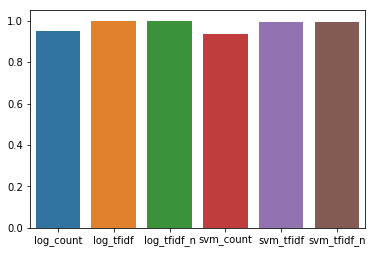

In [21]:
recall = [log_count[0], log_tfidf[0], log_tfidf_n[0], svm_count[0], svm_tfidf[0], svm_tfidf_n[0]]
labels = ['log_count', 'log_tfidf', 'log_tfidf_n', 'svm_count', 'svm_tfidf', 'svm_tfidf_n']
sns.barplot(labels, recall)

This shows that the recall scores are very similar for all classifier. However, it can be inferred that the tfidf classfiers are more accurate than the word count classifier. Let's check the f1 scores

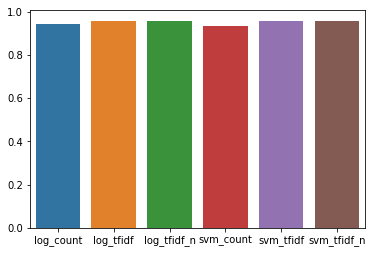

In [22]:
f1 = [log_count[1], log_tfidf[1], log_tfidf_n[1], svm_count[1], svm_tfidf[1], svm_tfidf_n[1]]
sns.barplot(labels, f1)

The scores are even closer in this one and so more difficult to read. The same inferences can be made though.

# Topic Modelling

Topic modelling is about finding words in a documents that map to a similar concept. In other words, What is he talking about? which can be difficult regarding who is speaking. This is useful in reducing the dimensions of the document and helps with classification and modelling. I really hope we don't have to know the background to these methods

The function below was copied from the tutorial, with the second half commented out to not print out the entire documents because they are long, and returning a list of lists of clusters to create the wordclouds from. This was difficult to comprehend. H is the topics found by the model, and this function prints the top words that correspond to each topic

In [23]:
def display_topics(H, W, feature_names, documents, no_top_words, no_top_documents):
    all_topics = []
    for topic_idx, topic in enumerate(H):
        print("Topic %d:" % (topic_idx))
        topics = [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]
        all_topics.append(topics)
        print(" ".join(topics)) 
        
#         top_doc_indices = np.argsort( W[:,topic_idx] )[::-1][0:no_top_documents]
#         for doc_index in top_doc_indices:
#             print(documents[doc_index])
    return all_topics

In [24]:
documents = list(X)
print(len(documents))

836


Picking the amount of topics is important as choosing too little may group unrelated words together, and picking too much will also have the same result as the model is fishing for words. I used an iterative process to see what made the most sense.

In [25]:
no_topics = 3
no_top_words = 10
no_top_documents = 2

#### NMF

Non Negative Matrix Factorization finds two non-negative matrices (W, H) whose product approximates the non-negative matrix X/ 

In [26]:
# NMF is able to use tf-idf. The documents are transformed into matrices in this step
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(documents)     #Vectorizing the documents
tfidf_feature_names = tfidf_vectorizer.get_feature_names()    #All the words used in the document

In [27]:
nmf_model = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)
nmf_W = nmf_model.transform(tfidf)    #Transform the data X according to the fitted NMF model
nmf_H = nmf_model.components_    #Factorization matrix, sometimes called ‘dictionary’

In [28]:
print("NMF Topics \n\n")
nmf_clusters = display_topics(nmf_H, nmf_W, tfidf_feature_names, documents, no_top_words, no_top_documents)

NMF Topics 


Topic 0:
going know people dont said theyre like im right want
Topic 1:
american country going america thank people hillary clinton jobs applause
Topic 2:
thanks exclusives highlights clicking digital interviews channel checking videos latest


Topic 0 seems to be Trump talking about himself. Topic 1 is about America and Hillary Clinton. Topic 2 appears to be about media. Increasing and decreasing the amount of topis didn't make the distinctions between the topis any clearer

#### LDA

Latent Dirichlet Allocation

In [29]:
# LDA can only use raw term counts for LDA because it is a probabilistic graphical model
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
tf = tf_vectorizer.fit_transform(documents)
tf_feature_names = tf_vectorizer.get_feature_names()

In [30]:
lda_model = LatentDirichletAllocation(n_components=no_topics, max_iter=5, learning_method='online', 
                                      learning_offset=50.,random_state=0).fit(tf)
lda_W = lda_model.transform(tf)
lda_H = lda_model.components_

In [31]:
print("\n\nLDA Topics \n\n")
lda_clusters = display_topics(lda_H, lda_W, tf_feature_names, documents, no_top_words, no_top_documents)



LDA Topics 


Topic 0:
president thank people american country america great going states united
Topic 1:
going people know president just want dont country right thats
Topic 2:
going people know dont said great want like right im


Topic 0 appears to be about how great America is. Topic 1 is about the the president and country. Topic 2 is about things being great?

#### SVD

Linear dimensionality reduction by means of truncated singular value decomposition

In [32]:
lsi_model = TruncatedSVD(n_components=no_topics, n_iter=7, random_state=42).fit(tf)
lsi_W = lsi_model.transform(tf)
lsi_H = lsi_model.components_

In [33]:
print("\n\nLSI Topics \n\n")
svd_clusters = display_topics(lsi_H, lsi_W, tf_feature_names, documents, no_top_words, no_top_documents)



LSI Topics 


Topic 0:
going people know dont said great like right want im
Topic 1:
american country america jobs clinton hillary thank president applause united
Topic 2:
going win jobs trade country folks theyre hillary mexico vote


Topic 0 is about how things are great. Topic 1 is about america and Hillary Clinton. Topic 2 is about jobs and and foreign affairs?

Obviously the models had a difficult time categorizing topics. This may be because the speeches were not the most eloquent or intelligent, or possibly because the speeches were on too wide a variety of topics? I'd like to see this done on Obama's speeches 

# Visualization

#### Choose the clusters obtained from a topic model algorithm from above and plot a word cloud for each of the clusters.

Text visualization can help the audience to easily see what the important or most influential words are

Since NMF produced arguably the most clear topics, wordclouds will be produced for each cluster

In [34]:
for cluster in nmf_clusters:
    print(cluster)

['going', 'know', 'people', 'dont', 'said', 'theyre', 'like', 'im', 'right', 'want']
['american', 'country', 'going', 'america', 'thank', 'people', 'hillary', 'clinton', 'jobs', 'applause']
['thanks', 'exclusives', 'highlights', 'clicking', 'digital', 'interviews', 'channel', 'checking', 'videos', 'latest']


The wordcloud module is used to plot the wordcloud

In [35]:
from wordcloud import WordCloud

In [36]:
plt.rcParams['font.size']=12                #10 
plt.rcParams['figure.subplot.bottom']=.1

The function method was copied from the tutorial

In [37]:
def print_cloud(data):
    wordcloud = WordCloud(
              background_color='white',
              max_words=200,
              max_font_size=40, 
              random_state=42
             ).generate(str(data))
    return wordcloud

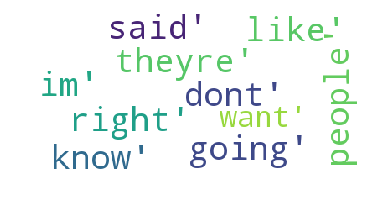

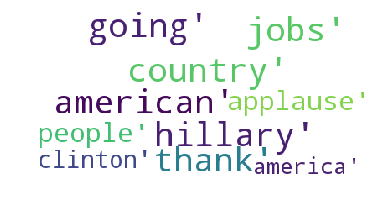

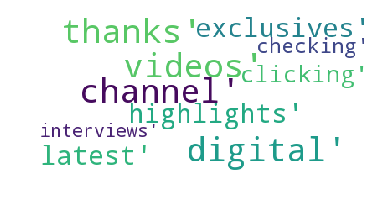

In [38]:
for cluster in nmf_clusters:
    wordcloud = print_cloud(cluster)
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

Doesn't look very exciting with just 10 words in it.